In [2]:
import xarray as xr
from helpers import get_TNH_idx
import matplotlib.pyplot as plt
import cartopy.feature as cfeature
import cartopy. crs as ccrs
import numpy as np
from calendar import month_name
from cmocean import cm
import matplotlib as mpl

TNH = get_TNH_idx(dropna=True)


#
mpl.rcParams['text.color'] = 'white'
mpl.rcParams['axes.labelcolor'] = 'white'
mpl.rcParams['xtick.color'] = 'white'
mpl.rcParams['ytick.color'] = 'white'
#

### REGRESSION onto precipitation, temperature maps

Text(0.5, 0.98, 'Correlations with TNH index')

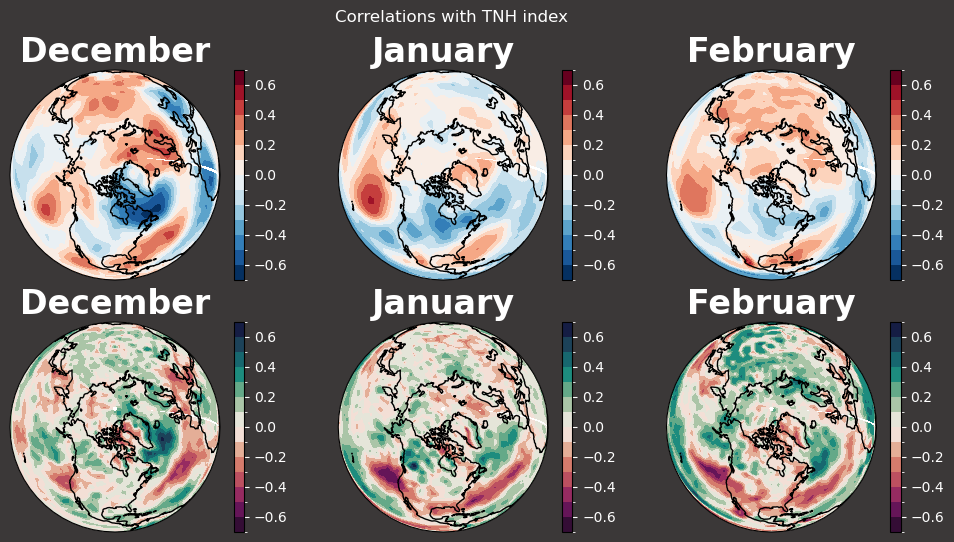

In [8]:
#RAINFALL# --------------------------------------------------------------------------------------
pr = xr.open_dataset('data/NCEP_reanalysis/prate.sfc.mon.mean.nc').prate
# linearly detrend the precipitation data:
coeffs       = pr.polyfit(dim='time',deg=1).polyfit_coefficients
pr_linfit    = xr.polyval(pr.time,coeffs=coeffs)
pr          -= pr_linfit
# compute and remove climatology:
pr_climatology = pr.sel(time=slice('1981','2010')).groupby('time.month').mean()
pr_a = pr.groupby('time.month') - pr_climatology
pr_a = pr_a.rolling(time=3,center=True).mean() # build mean over 3 months


#TEMPERATURES# ----------------------------------------------------------------------------------
t = xr.open_dataset('data/NCEP_reanalysis/air.mon.mean.nc').air
# linearly detrend the precipitation data:
t_coeffs    = t.polyfit(dim='time',deg=1).polyfit_coefficients
t_linfit    = xr.polyval(t.time,coeffs=t_coeffs)
t           = t - t_linfit
# compute and remove climatology:
t_climatology = t.sel(time=slice('1981','2010')).groupby('time.month').mean()
t_a = t.groupby('time.month') - t_climatology
t_a = t_a.rolling(time=3,center=True).mean() # build mean over 3 months

fig,axes = plt.subplots(2,3,figsize=(12,6),subplot_kw={'projection':ccrs.Orthographic(central_latitude=80,central_longitude=-90)}
                        ,facecolor='#3b3838')

# plotting and compute correlations
for ax,month in zip(axes.transpose(),[12,1,2]):
    TNH_ = TNH.loc[TNH.time.dt.month==month]
    t_ = t_a.sel(time=TNH_.time)
    pr_ = pr_a.sel(time=TNH_.time)

    t_cor = xr.corr(t_,TNH_,dim='time')
    pr_cor = xr.corr(pr_,TNH_,dim='time')

    t_cor.plot.contourf(ax=ax[0],transform=ccrs.PlateCarree(),levels=np.arange(-.7,.8,.1),add_colorbar=True)
    pr_cor.plot.contourf(ax=ax[1],transform=ccrs.PlateCarree(),levels=np.arange(-.7,.8,.1),add_colorbar=True,cmap=cm.curl_r)

    ax[0].add_feature(cfeature.COASTLINE)
    ax[1].add_feature(cfeature.COASTLINE)

    ax[0].set_title(f'{month_name[month]}',fontsize=24,weight='bold')#\nsurface temperature')
    ax[1].set_title(f'{month_name[month]}',fontsize=24,weight='bold')#\nprecipitation rate')

fig.savefig('figures/correlations.png',bbox_inches='tight',pad_inches=.1,facecolor='#3b3838')
fig.suptitle('Correlations with TNH index')


In [110]:
axes.shape

(2, 3)